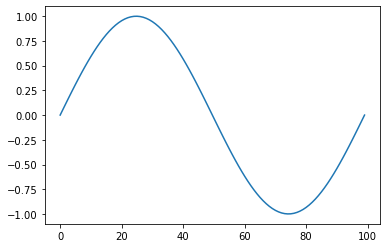

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.sin(np.linspace(0,2*np.pi, 100)))

In [2]:
import os
import math
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [85]:
#pip install segmentation_models_pytorch

In [3]:
path='E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR/'
dirs=glob.glob(path+'*')
dirs

['E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\10',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\13',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\15',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\19',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\2',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\20',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\21',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\22',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\3',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\31',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\32',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\33',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\34',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\36',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\37',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\38',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\39',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\5

In [4]:
img_path=[]
mask_path=[]
for i in dirs:
    img_dir=i+'/T2SPIR/DICOM_anon'
    mask_dir=i+'/T2SPIR/Ground'
    for file in os.listdir(img_dir):
        img=img_dir+'/{}'.format(file)
        img_path.append(img)
    for file in os.listdir(mask_dir):
        mask=mask_dir+'/{}'.format(file)
        mask_path.append(mask)
    

In [5]:
img_path[0:5]

['E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00001.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00002.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00003.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00004.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00005.dcm']

In [6]:
mask_path[0:5]

['E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00001.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00002.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00003.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00004.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00005.png']

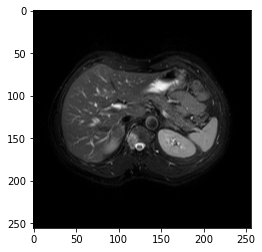

In [7]:
import pydicom
im=pydicom.read_file(img_path[25])
im_array=im.pixel_array
plt.imshow(im_array,cmap='gray')


In [8]:
mask=Image.open(mask_path[25])
#plt.imshow(mask,cmap='gray')

In [9]:
mask=Image.open(mask_path[25])
mask_array=np.array(mask)
np.max(mask_array)

252

In [10]:
#查看像素唯一值
np.unique(mask_array)

array([  0,  63, 126, 189, 252], dtype=uint8)

In [11]:
#编码图片上的像素值
idx={
    '0':0,
    '63':1,
    '126':2,
    '189':3,
    '252':4
}

In [12]:
def pixel_to_id(array):
    array=array.astype(str)
    ix,jx=array.shape
    for i in range(ix):
        for j in range(jx):
            pixel=array[i][j]
            pixelid=idx[pixel]
            array[i][j]=pixelid
    array=array.astype("int32")
    return array

In [13]:
id_maskarray=pixel_to_id(mask_array)
np.max(id_maskarray)

4

In [14]:
np.unique(id_maskarray)

array([0, 1, 2, 3, 4])

In [15]:
img_transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
label_transformer=transforms.Compose([
    transforms.Resize((256,256)),#保留1234的编码数值
])

In [16]:
class Liverdataset(Dataset):
    def __init__(self,img,mask,transformer,mask_transformer):
        self.img=img
        self.mask=mask
        self.transformer=transformer
        self.mask_transformer=mask_transformer
    def __getitem__(self,index):
        img=self.img[index]
        mask=self.mask[index]
        
        img_open=pydicom.read_file(img)
        img_array=img_open.pixel_array
        img_array = np.array(img_array, dtype=np.float32)
        #读取为image open PIL
        img_pic=Image.fromarray(img_array)
        ##transfomer
        img_tensor=self.transformer(img_pic)
        
        ###读取图片转numpy
        mask_open=Image.open(mask)
        mask_array=np.array(mask_open)
        ##像素编码
        mask_pixleID=pixel_to_id(mask_array)
        ###
        mask_pic=Image.fromarray(mask_pixleID)
        ###resize
        mask_resize=self.mask_transformer(mask_pic)##PIL
        mask_Rarray=np.array(mask_resize)
        ####numpy tensor
        mask_tensor=torch.from_numpy(mask_Rarray)
        mask_tensor=torch.squeeze(mask_tensor).type(torch.long)
        
        return img_tensor,mask_tensor
    
    def __len__(self):
        return len(self.img)
        
        

In [17]:
s=500
train_img=img_path[:s]
train_label=mask_path[:s]
test_img=img_path[s:]
test_label=mask_path[s:]

In [18]:
train_img[0:5]

['E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00001.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00002.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00003.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00004.dcm',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/DICOM_anon/IMG-0002-00005.dcm']

In [19]:
train_label[0:5]

['E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00001.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00002.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00003.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00004.png',
 'E:/data/Chaos/CHAOS_Train_Sets/Train_Sets/MR\\1/T2SPIR/Ground/IMG-0002-00005.png']

In [20]:
train_data=Liverdataset(train_img,train_label,img_transformer,label_transformer)
test_data=Liverdataset(test_img,test_label,img_transformer,label_transformer)
len(train_data)

500

In [21]:
dl_train=DataLoader(train_data,batch_size=6,shuffle=True)
dl_test=DataLoader(test_data,batch_size=6,shuffle=True)

In [22]:
img,label=next(iter(dl_test))
img.shape

torch.Size([6, 1, 256, 256])

In [23]:
label.shape

torch.Size([6, 256, 256])

In [24]:
img,label=next(iter(dl_test))
torch.unique(label[2])

tensor([0, 1, 4])

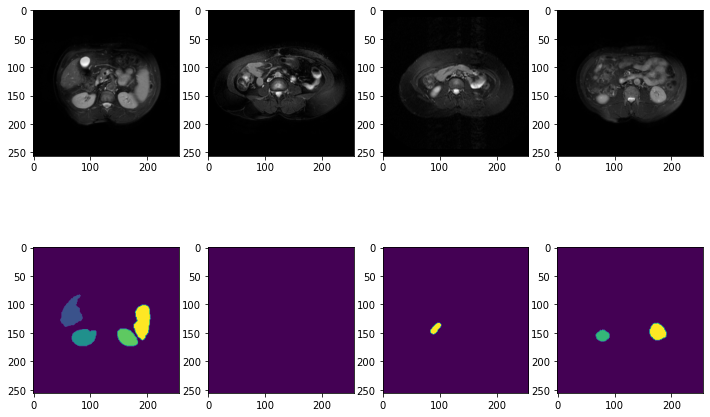

In [25]:
img,label=next(iter(dl_train))
plt.figure(figsize=(12,8))
for i,(img,label) in enumerate(zip(img[:4],label[:4])):
    img=torch.squeeze(img).numpy()
    label=label.numpy()
    plt.subplot(2,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.subplot(2,4,i+5)
    plt.imshow(label)

In [109]:
#pip install segmentation_models_pytorch

#pip install segmentation_models_pytorch

In [26]:
import segmentation_models_pytorch as smp


In [27]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

In [28]:
img,label=next(iter(dl_test))
y_pred = model(img)
y_pred.shape


torch.Size([6, 5, 256, 256])

In [29]:
model = model.to('cuda')

In [30]:
loss_fn=nn.CrossEntropyLoss()

In [31]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)




from tqdm import tqdm
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    epoch_iou = []

    model.train()
    for x, y in tqdm(testloader):

        x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

            intersection = torch.logical_and(y, y_pred)
            union = torch.logical_or(y, y_pred)
            batch_iou = torch.sum(intersection) / torch.sum(union)
            epoch_iou.append(batch_iou.item())

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)


    test_correct = 0
    test_total = 0
    test_running_loss = 0
    epoch_test_iou = []

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(testloader):

            x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

            intersection = torch.logical_and(y, y_pred)
            union = torch.logical_or(y, y_pred)
            batch_iou = torch.sum(intersection) / torch.sum(union)
            epoch_test_iou.append(batch_iou.item())


    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)


    print('epoch: ', epoch,
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'IOU:', round(np.mean(epoch_iou), 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3),
           'test_iou:', round(np.mean(epoch_test_iou), 3)
             )

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc




In [ ]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
epochs=200
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 dl_train,
                                                                 dl_test)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


epoch:  0 loss：  0.027 accuracy: 0.864 IOU: 0.378 test_loss：  0.085 test_accuracy: 0.894 test_iou: 0.239


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


epoch:  1 loss：  0.006 accuracy: 0.972 IOU: 0.516 test_loss：  0.02 test_accuracy: 0.973 test_iou: 0.54


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


epoch:  2 loss：  0.004 accuracy: 0.974 IOU: 0.547 test_loss：  0.012 test_accuracy: 0.978 test_iou: 0.618


100%|██████████| 21/21 [00:09<00:00,  2.24it/s]


epoch:  3 loss：  0.003 accuracy: 0.975 IOU: 0.564 test_loss：  0.011 test_accuracy: 0.977 test_iou: 0.593


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


epoch:  4 loss：  0.003 accuracy: 0.978 IOU: 0.61 test_loss：  0.01 test_accuracy: 0.983 test_iou: 0.672


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


epoch:  5 loss：  0.002 accuracy: 0.986 IOU: 0.775 test_loss：  0.008 test_accuracy: 0.987 test_iou: 0.791


100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


epoch:  6 loss：  0.002 accuracy: 0.987 IOU: 0.747 test_loss：  0.009 test_accuracy: 0.984 test_iou: 0.71


100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


epoch:  7 loss：  0.002 accuracy: 0.987 IOU: 0.74 test_loss：  0.01 test_accuracy: 0.984 test_iou: 0.685


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


epoch:  8 loss：  0.002 accuracy: 0.987 IOU: 0.765 test_loss：  0.006 test_accuracy: 0.989 test_iou: 0.816


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


epoch:  9 loss：  0.002 accuracy: 0.989 IOU: 0.812 test_loss：  0.005 test_accuracy: 0.991 test_iou: 0.855


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


epoch:  10 loss：  0.001 accuracy: 0.992 IOU: 0.866 test_loss：  0.006 test_accuracy: 0.989 test_iou: 0.82


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  11 loss：  0.001 accuracy: 0.992 IOU: 0.869 test_loss：  0.004 test_accuracy: 0.993 test_iou: 0.876


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


epoch:  12 loss：  0.001 accuracy: 0.993 IOU: 0.868 test_loss：  0.003 test_accuracy: 0.995 test_iou: 0.896


100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


epoch:  13 loss：  0.001 accuracy: 0.994 IOU: 0.885 test_loss：  0.003 test_accuracy: 0.995 test_iou: 0.905


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


epoch:  14 loss：  0.001 accuracy: 0.995 IOU: 0.897 test_loss：  0.003 test_accuracy: 0.994 test_iou: 0.89


100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


epoch:  15 loss：  0.001 accuracy: 0.995 IOU: 0.907 test_loss：  0.003 test_accuracy: 0.995 test_iou: 0.912


100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


epoch:  16 loss：  0.001 accuracy: 0.995 IOU: 0.9 test_loss：  0.003 test_accuracy: 0.995 test_iou: 0.916


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  17 loss：  0.001 accuracy: 0.995 IOU: 0.892 test_loss：  0.003 test_accuracy: 0.995 test_iou: 0.902


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


epoch:  18 loss：  0.001 accuracy: 0.996 IOU: 0.919 test_loss：  0.002 test_accuracy: 0.996 test_iou: 0.923


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


epoch:  19 loss：  0.001 accuracy: 0.996 IOU: 0.919 test_loss：  0.002 test_accuracy: 0.996 test_iou: 0.933


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  20 loss：  0.001 accuracy: 0.996 IOU: 0.929 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.94


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


epoch:  21 loss：  0.0 accuracy: 0.996 IOU: 0.919 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.942


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  22 loss：  0.0 accuracy: 0.996 IOU: 0.936 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.934


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  23 loss：  0.0 accuracy: 0.997 IOU: 0.936 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.942


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  24 loss：  0.0 accuracy: 0.996 IOU: 0.929 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.94


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


epoch:  25 loss：  0.0 accuracy: 0.996 IOU: 0.932 test_loss：  0.002 test_accuracy: 0.996 test_iou: 0.927


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


epoch:  26 loss：  0.0 accuracy: 0.996 IOU: 0.935 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.945


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  27 loss：  0.0 accuracy: 0.997 IOU: 0.939 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.946


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


epoch:  28 loss：  0.0 accuracy: 0.997 IOU: 0.945 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.951


100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


epoch:  29 loss：  0.0 accuracy: 0.997 IOU: 0.948 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.952


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


epoch:  30 loss：  0.0 accuracy: 0.997 IOU: 0.947 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.948


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  31 loss：  0.0 accuracy: 0.997 IOU: 0.951 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.956


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  32 loss：  0.0 accuracy: 0.997 IOU: 0.951 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.956


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


epoch:  33 loss：  0.0 accuracy: 0.997 IOU: 0.951 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.955


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  34 loss：  0.0 accuracy: 0.997 IOU: 0.953 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.959


100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


epoch:  35 loss：  0.0 accuracy: 0.997 IOU: 0.955 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.957


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  36 loss：  0.0 accuracy: 0.997 IOU: 0.955 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.959


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  37 loss：  0.0 accuracy: 0.998 IOU: 0.958 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.96


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


epoch:  38 loss：  0.0 accuracy: 0.998 IOU: 0.956 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.953


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  39 loss：  0.0 accuracy: 0.997 IOU: 0.955 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.957


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  40 loss：  0.0 accuracy: 0.997 IOU: 0.953 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.943


100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


epoch:  41 loss：  0.0 accuracy: 0.996 IOU: 0.929 test_loss：  0.008 test_accuracy: 0.986 test_iou: 0.9


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


epoch:  42 loss：  0.001 accuracy: 0.994 IOU: 0.895 test_loss：  0.004 test_accuracy: 0.993 test_iou: 0.869


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


epoch:  43 loss：  0.001 accuracy: 0.991 IOU: 0.847 test_loss：  0.007 test_accuracy: 0.987 test_iou: 0.789


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  44 loss：  0.001 accuracy: 0.992 IOU: 0.852 test_loss：  0.004 test_accuracy: 0.992 test_iou: 0.854


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  45 loss：  0.001 accuracy: 0.993 IOU: 0.87 test_loss：  0.002 test_accuracy: 0.996 test_iou: 0.922


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  46 loss：  0.001 accuracy: 0.995 IOU: 0.901 test_loss：  0.002 test_accuracy: 0.996 test_iou: 0.918


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  47 loss：  0.001 accuracy: 0.995 IOU: 0.919 test_loss：  0.002 test_accuracy: 0.996 test_iou: nan


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  48 loss：  0.0 accuracy: 0.996 IOU: 0.929 test_loss：  0.002 test_accuracy: 0.997 test_iou: 0.941


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  49 loss：  0.0 accuracy: 0.997 IOU: 0.944 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.95


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  50 loss：  0.0 accuracy: 0.997 IOU: 0.945 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.953


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  51 loss：  0.0 accuracy: 0.997 IOU: 0.952 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.953


100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


epoch:  52 loss：  0.0 accuracy: 0.997 IOU: 0.951 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.951


100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


epoch:  53 loss：  0.0 accuracy: 0.997 IOU: 0.952 test_loss：  0.001 test_accuracy: 0.997 test_iou: 0.956


100%|██████████| 21/21 [00:10<00:00,  1.99it/s]


epoch:  54 loss：  0.0 accuracy: 0.997 IOU: 0.954 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.955


100%|██████████| 21/21 [00:10<00:00,  2.00it/s]


epoch:  55 loss：  0.0 accuracy: 0.998 IOU: 0.96 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.959


100%|██████████| 21/21 [00:23<00:00,  1.12s/it]


epoch:  56 loss：  0.0 accuracy: 0.998 IOU: 0.952 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.963


100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


epoch:  57 loss：  0.0 accuracy: 0.998 IOU: 0.959 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.963


100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


epoch:  58 loss：  0.0 accuracy: 0.998 IOU: 0.958 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.96


100%|██████████| 21/21 [00:10<00:00,  2.02it/s]


epoch:  59 loss：  0.0 accuracy: 0.998 IOU: 0.952 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.961


100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


epoch:  60 loss：  0.0 accuracy: 0.998 IOU: 0.957 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.962


100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


epoch:  61 loss：  0.0 accuracy: 0.998 IOU: 0.959 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.964


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


epoch:  62 loss：  0.0 accuracy: 0.998 IOU: 0.962 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.963


100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


epoch:  63 loss：  0.0 accuracy: 0.998 IOU: 0.96 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.964


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


epoch:  64 loss：  0.0 accuracy: 0.998 IOU: 0.964 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.967


100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


epoch:  65 loss：  0.0 accuracy: 0.998 IOU: 0.965 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.964


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  66 loss：  0.0 accuracy: 0.998 IOU: 0.956 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.969


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  67 loss：  0.0 accuracy: 0.998 IOU: 0.966 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.963


100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


epoch:  68 loss：  0.0 accuracy: 0.998 IOU: 0.967 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.971


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  69 loss：  0.0 accuracy: 0.998 IOU: 0.969 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.972


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  70 loss：  0.0 accuracy: 0.998 IOU: 0.969 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.97


100%|██████████| 21/21 [00:10<00:00,  2.05it/s]


epoch:  71 loss：  0.0 accuracy: 0.998 IOU: 0.97 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.973


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  72 loss：  0.0 accuracy: 0.998 IOU: 0.97 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.97


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


epoch:  73 loss：  0.0 accuracy: 0.998 IOU: 0.97 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.973


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  74 loss：  0.0 accuracy: 0.998 IOU: 0.968 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.969


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  75 loss：  0.0 accuracy: 0.998 IOU: 0.971 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.971


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  76 loss：  0.0 accuracy: 0.998 IOU: 0.971 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.975


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  77 loss：  0.0 accuracy: 0.998 IOU: 0.973 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.976


100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


epoch:  78 loss：  0.0 accuracy: 0.998 IOU: 0.975 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.978


100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


epoch:  79 loss：  0.0 accuracy: 0.998 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.977


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  80 loss：  0.0 accuracy: 0.998 IOU: 0.975 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.978


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  81 loss：  0.0 accuracy: 0.998 IOU: 0.977 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.98


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


epoch:  82 loss：  0.0 accuracy: 0.998 IOU: 0.975 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.98


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


epoch:  83 loss：  0.0 accuracy: 0.998 IOU: 0.974 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.977


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


epoch:  84 loss：  0.0 accuracy: 0.998 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.977


100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


epoch:  85 loss：  0.0 accuracy: 0.998 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.978


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  86 loss：  0.0 accuracy: 0.998 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.979


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  87 loss：  0.0 accuracy: 0.999 IOU: 0.977 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.981


100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


epoch:  88 loss：  0.0 accuracy: 0.999 IOU: 0.979 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.98


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  89 loss：  0.0 accuracy: 0.999 IOU: 0.977 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.979


100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


epoch:  90 loss：  0.0 accuracy: 0.999 IOU: 0.979 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.981


100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


epoch:  91 loss：  0.0 accuracy: 0.999 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.979


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  92 loss：  0.0 accuracy: 0.999 IOU: 0.978 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.98


100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


epoch:  93 loss：  0.0 accuracy: 0.998 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.976


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


epoch:  94 loss：  0.0 accuracy: 0.999 IOU: 0.977 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.981


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  95 loss：  0.0 accuracy: 0.999 IOU: 0.979 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.981


100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


epoch:  96 loss：  0.0 accuracy: 0.999 IOU: 0.978 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.98


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  97 loss：  0.0 accuracy: 0.999 IOU: 0.979 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


epoch:  98 loss：  0.0 accuracy: 0.999 IOU: 0.981 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


epoch:  99 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


epoch:  100 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.984


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


epoch:  101 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.982


100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


epoch:  102 loss：  0.0 accuracy: 0.999 IOU: 0.982 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.984


100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


epoch:  103 loss：  0.0 accuracy: 0.999 IOU: 0.98 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


epoch:  104 loss：  0.0 accuracy: 0.999 IOU: 0.981 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.985


100%|██████████| 21/21 [14:44<00:00, 42.12s/it]  


epoch:  105 loss：  0.0 accuracy: 0.999 IOU: 0.978 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.981


100%|██████████| 21/21 [00:10<00:00,  2.05it/s]


epoch:  108 loss：  0.0 accuracy: 0.998 IOU: 0.973 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.976


100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


epoch:  109 loss：  0.0 accuracy: 0.998 IOU: 0.974 test_loss：  0.001 test_accuracy: 0.998 test_iou: 0.974


100%|██████████| 21/21 [00:11<00:00,  1.75it/s]


epoch:  110 loss：  0.0 accuracy: 0.998 IOU: 0.976 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.978


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


epoch:  111 loss：  0.0 accuracy: 0.999 IOU: 0.978 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


epoch:  112 loss：  0.0 accuracy: 0.999 IOU: 0.98 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.984


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


epoch:  113 loss：  0.0 accuracy: 0.999 IOU: 0.98 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.98


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


epoch:  114 loss：  0.0 accuracy: 0.999 IOU: 0.978 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.984


100%|██████████| 21/21 [00:20<00:00,  1.01it/s]


epoch:  115 loss：  0.0 accuracy: 0.999 IOU: 0.981 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.985


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


epoch:  116 loss：  0.0 accuracy: 0.999 IOU: 0.982 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


epoch:  117 loss：  0.0 accuracy: 0.999 IOU: 0.982 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


epoch:  118 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.985


100%|██████████| 21/21 [00:24<00:00,  1.19s/it]


epoch:  119 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


epoch:  120 loss：  0.0 accuracy: 0.999 IOU: 0.984 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.984


100%|██████████| 21/21 [00:10<00:00,  2.05it/s]


epoch:  121 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


epoch:  122 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.989


100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


epoch:  123 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:12<00:00,  1.68it/s]


epoch:  124 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


epoch:  125 loss：  0.0 accuracy: 0.999 IOU: 0.98 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.978


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


epoch:  126 loss：  0.0 accuracy: 0.999 IOU: 0.978 test_loss：  0.001 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


epoch:  127 loss：  0.0 accuracy: 0.999 IOU: 0.982 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.985


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


epoch:  128 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


epoch:  129 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.984


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


epoch:  130 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.989


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  131 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.989


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


epoch:  132 loss：  0.0 accuracy: 0.999 IOU: 0.987 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:11<00:00,  1.78it/s]


epoch:  133 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


epoch:  134 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


epoch:  135 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


epoch:  136 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:11<00:00,  1.91it/s]


epoch:  137 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.985


100%|██████████| 21/21 [00:11<00:00,  1.87it/s]


epoch:  138 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.986


100%|██████████| 21/21 [00:13<00:00,  1.59it/s]


epoch:  139 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:13<00:00,  1.51it/s]


epoch:  140 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:13<00:00,  1.52it/s]


epoch:  141 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


epoch:  142 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


epoch:  143 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


epoch:  144 loss：  0.0 accuracy: 0.999 IOU: 0.987 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:14<00:00,  1.47it/s]


epoch:  145 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.985


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


epoch:  146 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:13<00:00,  1.58it/s]


epoch:  147 loss：  0.0 accuracy: 0.999 IOU: 0.985 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


epoch:  148 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


epoch:  149 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:13<00:00,  1.57it/s]


epoch:  150 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:13<00:00,  1.58it/s]


epoch:  151 loss：  0.0 accuracy: 0.999 IOU: 0.987 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


epoch:  152 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


epoch:  153 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:13<00:00,  1.50it/s]


epoch:  154 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:13<00:00,  1.54it/s]


epoch:  155 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.993


100%|██████████| 21/21 [00:13<00:00,  1.53it/s]


epoch:  156 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:13<00:00,  1.52it/s]


epoch:  157 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:14<00:00,  1.48it/s]


epoch:  158 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.994


100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


epoch:  159 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.993


100%|██████████| 21/21 [00:14<00:00,  1.46it/s]


epoch:  160 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.993


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


epoch:  161 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


epoch:  162 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:14<00:00,  1.50it/s]


epoch:  163 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


epoch:  164 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.989


100%|██████████| 21/21 [00:11<00:00,  1.78it/s]


epoch:  165 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.90it/s]


epoch:  166 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  167 loss：  0.0 accuracy: 0.999 IOU: 0.989 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  168 loss：  0.0 accuracy: 0.999 IOU: 0.984 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.983


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  169 loss：  0.0 accuracy: 0.999 IOU: 0.983 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.987


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  170 loss：  0.0 accuracy: 0.999 IOU: 0.984 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


epoch:  171 loss：  0.0 accuracy: 0.999 IOU: 0.986 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.988


100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


epoch:  172 loss：  0.0 accuracy: 0.999 IOU: 0.988 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.99


100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


epoch:  173 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


epoch:  174 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


epoch:  175 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.994


100%|██████████| 21/21 [00:10<00:00,  1.91it/s]


epoch:  176 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


epoch:  177 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


epoch:  178 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


epoch:  179 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


epoch:  180 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


epoch:  181 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.79it/s]


epoch:  182 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  183 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.991


100%|██████████| 21/21 [00:11<00:00,  1.86it/s]


epoch:  184 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.85it/s]


epoch:  185 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


epoch:  186 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


epoch:  187 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  188 loss：  0.0 accuracy: 0.999 IOU: 0.991 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.994


100%|██████████| 21/21 [00:11<00:00,  1.87it/s]


epoch:  189 loss：  0.0 accuracy: 0.999 IOU: 0.99 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  190 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  191 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 1.0 test_iou: 0.993


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


epoch:  192 loss：  0.0 accuracy: 0.999 IOU: 0.992 test_loss：  0.0 test_accuracy: 0.999 test_iou: 0.992


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


epoch:  193 loss：  0.0 accuracy: 0.999 IOU: 0.939 test_loss：  0.124 test_accuracy: 0.85 test_iou: 0.197


100%|██████████| 21/21 [00:11<00:00,  1.89it/s]


epoch:  194 loss：  0.005 accuracy: 0.963 IOU: 0.413 test_loss：  0.3 test_accuracy: 0.799 test_iou: 0.196


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


epoch:  195 loss：  0.003 accuracy: 0.979 IOU: 0.667 test_loss：  0.011 test_accuracy: 0.977 test_iou: 0.681


100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


epoch:  196 loss：  0.002 accuracy: 0.984 IOU: 0.738 test_loss：  0.009 test_accuracy: 0.985 test_iou: 0.66


100%|██████████| 21/21 [00:11<00:00,  1.83it/s]


epoch:  197 loss：  0.001 accuracy: 0.989 IOU: 0.795 test_loss：  0.007 test_accuracy: 0.985 test_iou: 0.764


100%|██████████| 21/21 [00:11<00:00,  1.84it/s]


epoch:  198 loss：  0.001 accuracy: 0.99 IOU: 0.799 test_loss：  0.005 test_accuracy: 0.99 test_iou: 0.817


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]

epoch:  199 loss：  0.001 accuracy: 0.989 IOU: 0.808 test_loss：  0.004 test_accuracy: 0.993 test_iou: 0.877


In [ ]:
epochs = 100


In [34]:
image, mask = next(iter(dl_train))
image=image.to('cuda')

model.eval()
pred_mask = model(image)
image=torch.squeeze(image) 
image.shape

torch.Size([6, 256, 256])

In [35]:
mask=torch.squeeze(mask)
mask.shape

torch.Size([6, 256, 256])

In [36]:
pred_mask
pred_mask.shape
pred_mask=pred_mask.cpu()
pred_mask.shape

torch.Size([6, 5, 256, 256])

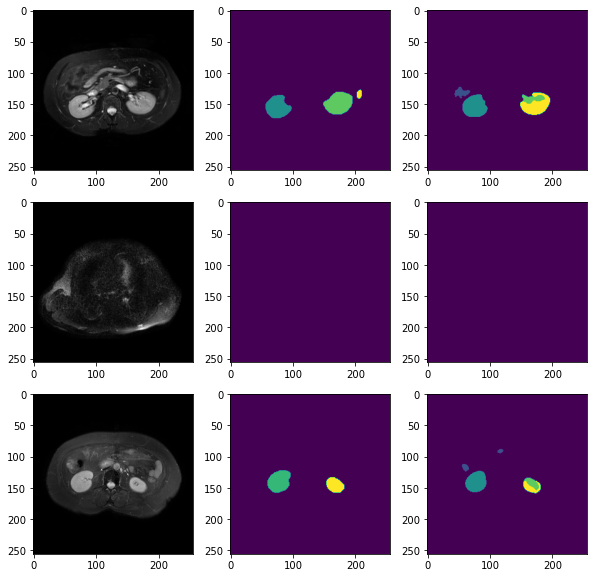

In [41]:
num=3
plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i-6].cpu().numpy(),cmap='gray')
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i-6].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i-6].permute(1,2,0), axis=-1).detach().numpy())
    plt.savefig('E:/SRP/多组织分割/Unet/output/Useg_train200_2.png')

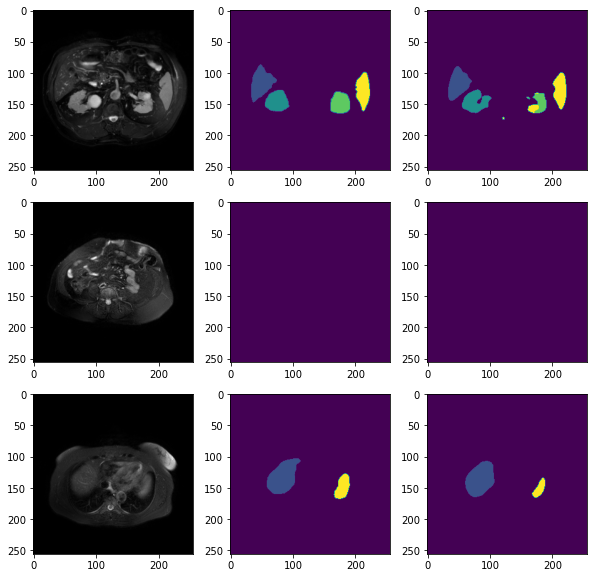

In [45]:
image, mask = next(iter(dl_test))
image=image.to('cuda')
model.eval()
pred_mask = model(image)
image=torch.squeeze(image) 
image.shape
mask=torch.squeeze(mask)
mask.shape
pred_mask
pred_mask.shape
pred_mask=pred_mask.cpu()
pred_mask.shape
num=3
plt.figure(figsize=(10, 10))
for i in range(num):
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i-1].cpu().numpy(),cmap='gray')
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i-1].cpu().numpy())
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i-1].permute(1,2,0), axis=-1).detach().numpy())
    plt.savefig('E:/SRP/多组织分割/Unet/output/seg_test200_2.png')